## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [24]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [25]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [26]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [27]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [28]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [29]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [30]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [31]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day',  
                 'buoyancy', 'diffusivity', 'temp_initial00', 
                'temp_heat01', 'temp_diff02', 'temp_total05',
                'ice', 'snow', 'snowice']
m0_output_columns =['temp_conv04']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/direct_model_train_time.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [32]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [33]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [34]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [35]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [36]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [37]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [38]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [39]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [62]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [41]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.011512252
RMSE of after m0 0.052255746
RMSE of after m0 0.03278068
RMSE of after m0 0.014023994
RMSE of after m0 0.013850591
RMSE of after m0 0.014166025
RMSE of after m0 0.013289089
RMSE of after m0 0.013248466
RMSE of after m0 0.013504157
RMSE of after m0 0.013061308
RMSE of after m0 0.013714504
RMSE of after m0 0.016008234
RMSE of after m0 0.013666918
RMSE of after m0 0.013311305
RMSE of after m0 0.0152135445
RMSE of after m0 0.016050458
RMSE of after m0 0.014071535
RMSE of after m0 0.012692198
RMSE of after m0 0.014585136
RMSE of after m0 0.0145391235
RMSE of after m0 0.014289534
RMSE of after m0 0.01636267
RMSE of after m0 0.015218807
RMSE of after m0 0.015187568
RMSE of after m0 0.01312945
RMSE of after m0 0.013103348
RMSE of after m0 0.015433803
RMSE of after m0 0.015419529
RMSE of after m0 0.01636357
RMSE of after m0 0.01527565
RMSE of after m0 0.013766097
RMSE of after m0 0.01431224
RMSE of after m0 0.01440721
RMSE of after m0 0.015142415
RMSE of after m0 0.

RMSE of after m0 0.009957359
RMSE of after m0 0.0068128505
RMSE of after m0 0.008502444
RMSE of after m0 0.007684538
RMSE of after m0 0.008293657
RMSE of after m0 0.0082792435
RMSE of after m0 0.013333899
RMSE of after m0 0.01049882
RMSE of after m0 0.008762163
RMSE of after m0 0.0089827785
RMSE of after m0 0.008131599
RMSE of after m0 0.010032509
RMSE of after m0 0.008223465
RMSE of after m0 0.008071015
RMSE of after m0 0.008564774
RMSE of after m0 0.008275129
RMSE of after m0 0.0098085515
RMSE of after m0 0.01601421
RMSE of after m0 0.013240058
RMSE of after m0 0.022173788
RMSE of after m0 0.025267828
RMSE of after m0 0.01306855
RMSE of after m0 0.016324399
RMSE of after m0 0.019841138
RMSE of after m0 0.009036704
RMSE of after m0 0.022472091
RMSE of after m0 0.01929186
RMSE of after m0 0.012684079
RMSE of after m0 0.01172741
RMSE of after m0 0.012493016
RMSE of after m0 0.009402024
RMSE of after m0 0.022881687
RMSE of after m0 0.0292289
RMSE of after m0 0.01691741
RMSE of after m0 0

RMSE of after m0 0.018279107
RMSE of after m0 0.018273262
RMSE of after m0 0.019581832
RMSE of after m0 0.01776695
RMSE of after m0 0.01995161
RMSE of after m0 0.01857867
RMSE of after m0 0.023048386
RMSE of after m0 0.006543033
RMSE of after m0 0.0071823685
RMSE of after m0 0.013781055
RMSE of after m0 0.01157701
RMSE of after m0 0.0060360087
RMSE of after m0 0.0057971184
RMSE of after m0 0.0064890026
RMSE of after m0 0.007963419
RMSE of after m0 0.008645325
RMSE of after m0 0.00803535
RMSE of after m0 0.007815442
RMSE of after m0 0.0056131245
RMSE of after m0 0.015135119
RMSE of after m0 0.030991776
RMSE of after m0 0.018231306
RMSE of after m0 0.033386055
RMSE of after m0 0.008094524
RMSE of after m0 0.0056135873
RMSE of after m0 0.0054859472
RMSE of after m0 0.005831869
RMSE of after m0 0.0054198313
RMSE of after m0 0.00812265
RMSE of after m0 0.009501545
RMSE of after m0 0.006909731
RMSE of after m0 0.0077098296
RMSE of after m0 0.0074785114
RMSE of after m0 0.015586653
RMSE of af

RMSE of after m0 0.012143452
RMSE of after m0 0.013724436
RMSE of after m0 0.011261462
RMSE of after m0 0.011845323
RMSE of after m0 0.010832083
RMSE of after m0 0.008662168
RMSE of after m0 0.0130542945
RMSE of after m0 0.012539473
RMSE of after m0 0.012138881
RMSE of after m0 0.008691298
RMSE of after m0 0.008987609
RMSE of after m0 0.011209232
RMSE of after m0 0.0138165485
RMSE of after m0 0.014152497
RMSE of after m0 0.014185503
RMSE of after m0 0.0148736
RMSE of after m0 0.0138280615
RMSE of after m0 0.018554365
RMSE of after m0 0.018828003
RMSE of after m0 0.014412031
RMSE of after m0 0.012411298
RMSE of after m0 0.012395853
RMSE of after m0 0.012140905
RMSE of after m0 0.014551473
RMSE of after m0 0.01415971
RMSE of after m0 0.0148327155
RMSE of after m0 0.013276396
RMSE of after m0 0.012933261
RMSE of after m0 0.015068425
RMSE of after m0 0.015178501
RMSE of after m0 0.01472821
RMSE of after m0 0.015290173
RMSE of after m0 0.013172935
RMSE of after m0 0.01475942
RMSE of after m

RMSE of after m0 0.009580511
RMSE of after m0 0.008627091
RMSE of after m0 0.008644508
RMSE of after m0 0.009362203
RMSE of after m0 0.008484449
RMSE of after m0 0.008222719
RMSE of after m0 0.009404352
RMSE of after m0 0.01886538
RMSE of after m0 0.0140006635
RMSE of after m0 0.009854261
RMSE of after m0 0.009333377
RMSE of after m0 0.0073475
RMSE of after m0 0.009028247
RMSE of after m0 0.009927504
RMSE of after m0 0.008972604
RMSE of after m0 0.010243633
RMSE of after m0 0.007917778
RMSE of after m0 0.008650327
RMSE of after m0 0.008555047
RMSE of after m0 0.016702829
RMSE of after m0 0.013506361
RMSE of after m0 0.017721646
RMSE of after m0 0.009050488
RMSE of after m0 0.008200029
RMSE of after m0 0.008821257
RMSE of after m0 0.024770554
RMSE of after m0 0.021938182
RMSE of after m0 0.01682203
RMSE of after m0 0.014217854
RMSE of after m0 0.0078563355
RMSE of after m0 0.011718463
RMSE of after m0 0.0108604105
RMSE of after m0 0.012158198
RMSE of after m0 0.009358546
RMSE of after m

RMSE of after m0 0.008487531
RMSE of after m0 0.008012696
RMSE of after m0 0.010399151
RMSE of after m0 0.013312333
RMSE of after m0 0.012477302
RMSE of after m0 0.018905256
RMSE of after m0 0.013702491
RMSE of after m0 0.012848251
RMSE of after m0 0.008886089
RMSE of after m0 0.009280978
RMSE of after m0 0.01082399
RMSE of after m0 0.011269988
RMSE of after m0 0.009546742
RMSE of after m0 0.009175906
RMSE of after m0 0.006509063
RMSE of after m0 0.0076082465
RMSE of after m0 0.011913396
RMSE of after m0 0.009092016
RMSE of after m0 0.007690483
RMSE of after m0 0.0077083306
RMSE of after m0 0.0064470842
RMSE of after m0 0.0068520424
RMSE of after m0 0.0071236785
RMSE of after m0 0.007288384
RMSE of after m0 0.007221038
RMSE of after m0 0.009631713
RMSE of after m0 0.0066671004
RMSE of after m0 0.007707164
RMSE of after m0 0.007284093
RMSE of after m0 0.007513723
RMSE of after m0 0.008595424
RMSE of after m0 0.006613465
RMSE of after m0 0.0104252435
RMSE of after m0 0.0106028225
RMSE of

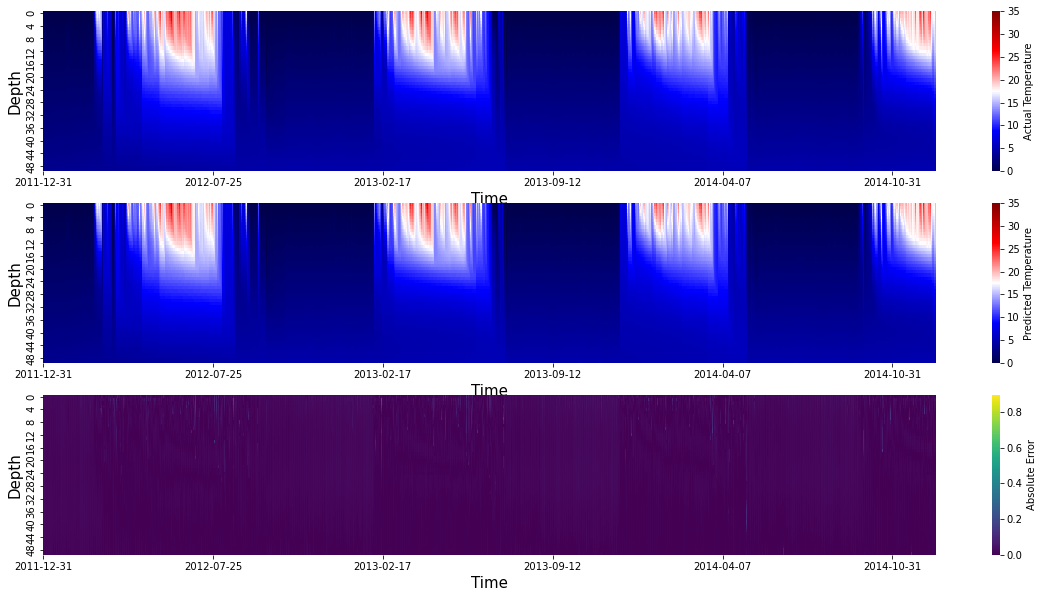

In [42]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

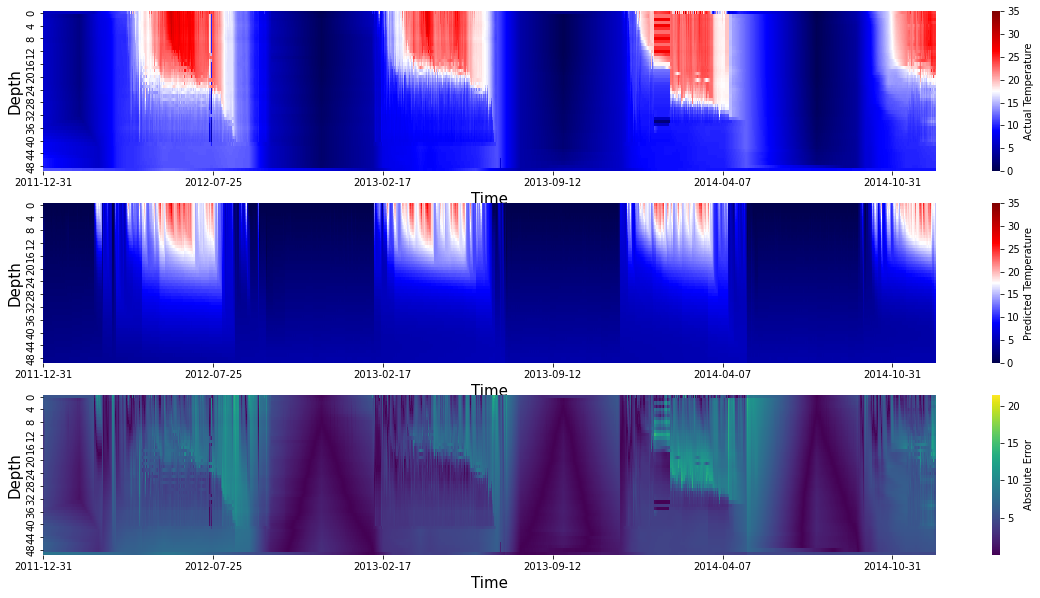

In [43]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [44]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.006775576
RMSE of after m0 0.006456804
RMSE of after m0 0.0072900676
RMSE of after m0 0.0075830985
RMSE of after m0 0.0074228453
RMSE of after m0 0.0076671233
RMSE of after m0 0.009064886
RMSE of after m0 0.011831956
RMSE of after m0 0.010758576
RMSE of after m0 0.0065710284
RMSE of after m0 0.006844323
RMSE of after m0 0.00793829
RMSE of after m0 0.008027544
RMSE of after m0 0.008686456
RMSE of after m0 0.008545842
RMSE of after m0 0.007622324
RMSE of after m0 0.008080294
RMSE of after m0 0.009953266
RMSE of after m0 0.008835508
RMSE of after m0 0.0076844483
RMSE of after m0 0.006756215
RMSE of after m0 0.014371104
RMSE of after m0 0.010970992
RMSE of after m0 0.0058297664
RMSE of after m0 0.0068972167
RMSE of after m0 0.008276818
RMSE of after m0 0.0066968133
RMSE of after m0 0.008758224
RMSE of after m0 0.008109601
RMSE of after m0 0.008298328
RMSE of after m0 0.007730686
RMSE of after m0 0.008913384
RMSE of after m0 0.008951262
RMSE of after m0 0.009365394
RMSE o

RMSE of after m0 0.009778689
RMSE of after m0 0.010654595
RMSE of after m0 0.009043992
RMSE of after m0 0.009998045
RMSE of after m0 0.017571634
RMSE of after m0 0.014144769
RMSE of after m0 0.015958138
RMSE of after m0 0.01036956
RMSE of after m0 0.008836104
RMSE of after m0 0.011911002
RMSE of after m0 0.009960766
RMSE of after m0 0.010602834
RMSE of after m0 0.009895456
RMSE of after m0 0.010148676
RMSE of after m0 0.009112573
RMSE of after m0 0.010932259
RMSE of after m0 0.01041587
RMSE of after m0 0.0070684184
RMSE of after m0 0.00835402
RMSE of after m0 0.008517677
RMSE of after m0 0.00901844
RMSE of after m0 0.00972388
RMSE of after m0 0.04315815
RMSE of after m0 0.034447
RMSE of after m0 0.01880154
RMSE of after m0 0.027817389
RMSE of after m0 0.021166833
RMSE of after m0 0.016620524
RMSE of after m0 0.0067939064
RMSE of after m0 0.0075018476
RMSE of after m0 0.015620859
RMSE of after m0 0.0111785
RMSE of after m0 0.01604786
RMSE of after m0 0.012629955
RMSE of after m0 0.00951

RMSE of after m0 0.041426238
RMSE of after m0 0.012836271
RMSE of after m0 0.013372008
RMSE of after m0 0.013840983
RMSE of after m0 0.0124344705
RMSE of after m0 0.010729816
RMSE of after m0 0.009878964
RMSE of after m0 0.01043229
RMSE of after m0 0.010431878
RMSE of after m0 0.011504435
RMSE of after m0 0.01051756
RMSE of after m0 0.013700741
RMSE of after m0 0.012307279
RMSE of after m0 0.010654477
RMSE of after m0 0.010913322
RMSE of after m0 0.011528694
RMSE of after m0 0.009395139
RMSE of after m0 0.008749206
RMSE of after m0 0.009484507
RMSE of after m0 0.011082085
RMSE of after m0 0.011078585
RMSE of after m0 0.011952513
RMSE of after m0 0.011672855
RMSE of after m0 0.011866466
RMSE of after m0 0.011408373
RMSE of after m0 0.01055754
RMSE of after m0 0.010335515
RMSE of after m0 0.011615814
RMSE of after m0 0.011639745
RMSE of after m0 0.010644167
RMSE of after m0 0.009564507
RMSE of after m0 0.01091282
RMSE of after m0 0.009741546
RMSE of after m0 0.012075509
RMSE of after m0 

RMSE of after m0 0.0131329205
RMSE of after m0 0.019074382
RMSE of after m0 0.01885329
RMSE of after m0 0.0114824055
RMSE of after m0 0.008722634
RMSE of after m0 0.012104322
RMSE of after m0 0.010709411
RMSE of after m0 0.01041932
RMSE of after m0 0.010387157
RMSE of after m0 0.010092387
RMSE of after m0 0.010550502
RMSE of after m0 0.009249826
RMSE of after m0 0.009690943
RMSE of after m0 0.0167831
RMSE of after m0 0.028564926
RMSE of after m0 0.010391422
RMSE of after m0 0.006624805
RMSE of after m0 0.0066653662
RMSE of after m0 0.008033559
RMSE of after m0 0.0074447636
RMSE of after m0 0.009240219
RMSE of after m0 0.0083949845
RMSE of after m0 0.0076541356
RMSE of after m0 0.008611847
RMSE of after m0 0.008496746
RMSE of after m0 0.008087619
RMSE of after m0 0.007949112
RMSE of after m0 0.010175695
RMSE of after m0 0.010960048
RMSE of after m0 0.006668042
RMSE of after m0 0.006973241
RMSE of after m0 0.008167513
RMSE of after m0 0.01022707
RMSE of after m0 0.010837616
RMSE of after

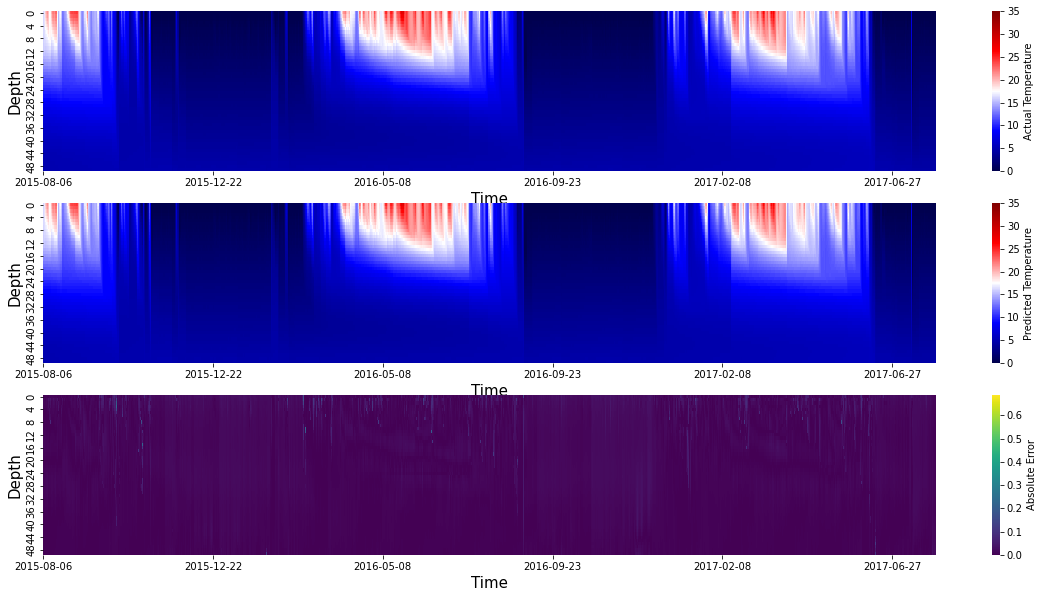

In [45]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

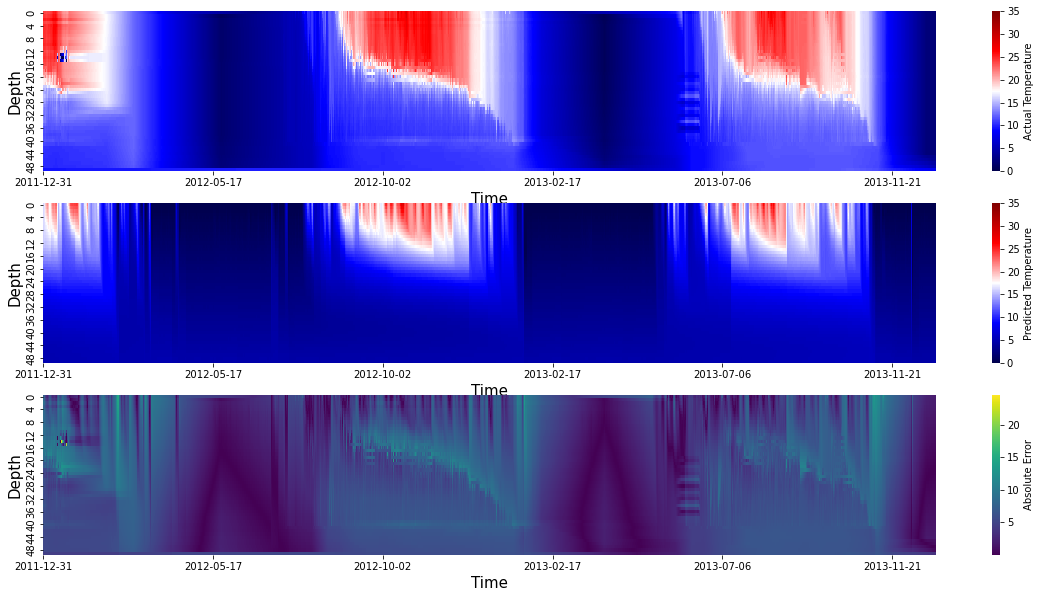

In [46]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [47]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.013291250906529615, Train L2 Error: 0.001750358174506588
Test RMSE: 0.012914304745543781, Train L2 Error: 0.0016236128994622687


## Mixing Model

## Convection Model

## Ice Model

# Finetuning

In [48]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(direct_model.parameters()) 
optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [49]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [50]:
#freeze_model(heating_model)

unfreeze_model(direct_model)


# Finetuning on Observed Temperature

In [51]:
direct_model.train()


n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out0 = torch.tensor(train_mean[m0_output_column_ix[0]]).float().to(device)
std_out0 = torch.tensor(train_std[m0_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input

train_loss = []
LOSS_m0 = []


for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0

    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out0)/std_out0
        
        loss_m0 = criterion(m0_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m0
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()

    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)

    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)

    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:21<5:59:20, 21.58s/it]

Epoch : 0, Train_loss: 0.683488121747862, Loss m0: 0.683488121747862


  5%|▌         | 51/1000 [19:21<5:54:20, 22.40s/it]

Epoch : 50, Train_loss: 0.14091330816246586, Loss m0: 0.14091330816246586


 10%|█         | 101/1000 [37:19<5:57:02, 23.83s/it]

Epoch : 100, Train_loss: 0.11813751182590312, Loss m0: 0.11813751182590312


 15%|█▌        | 151/1000 [55:11<4:40:04, 19.79s/it]

Epoch : 150, Train_loss: 0.10368133324464897, Loss m0: 0.10368133324464897


 20%|██        | 201/1000 [1:11:34<4:20:39, 19.57s/it]

Epoch : 200, Train_loss: 0.09243808447085887, Loss m0: 0.09243808447085887


 25%|██▌       | 251/1000 [1:28:21<4:12:48, 20.25s/it]

Epoch : 250, Train_loss: 0.08483753892497475, Loss m0: 0.08483753892497475


 30%|███       | 301/1000 [1:45:24<4:17:13, 22.08s/it]

Epoch : 300, Train_loss: 0.08035472773354269, Loss m0: 0.08035472773354269


 35%|███▌      | 351/1000 [2:03:17<3:49:07, 21.18s/it]

Epoch : 350, Train_loss: 0.07682111150678365, Loss m0: 0.07682111150678365


 40%|████      | 401/1000 [2:19:54<3:18:51, 19.92s/it]

Epoch : 400, Train_loss: 0.0730499795412129, Loss m0: 0.0730499795412129


 45%|████▌     | 451/1000 [2:37:42<3:00:44, 19.75s/it]

Epoch : 450, Train_loss: 0.06899919897817779, Loss m0: 0.06899919897817779


 50%|█████     | 501/1000 [2:54:59<2:54:55, 21.03s/it]

Epoch : 500, Train_loss: 0.06426226161339194, Loss m0: 0.06426226161339194


 55%|█████▌    | 551/1000 [3:13:33<2:34:15, 20.61s/it]

Epoch : 550, Train_loss: 0.05881261022745824, Loss m0: 0.05881261022745824


 60%|██████    | 601/1000 [3:30:56<2:29:27, 22.47s/it]

Epoch : 600, Train_loss: 0.05502396988288053, Loss m0: 0.05502396988288053


 65%|██████▌   | 651/1000 [3:51:27<1:54:00, 19.60s/it]

Epoch : 650, Train_loss: 0.052303577015798776, Loss m0: 0.052303577015798776


 70%|███████   | 701/1000 [4:07:59<1:44:29, 20.97s/it]

Epoch : 700, Train_loss: 0.05072223539532786, Loss m0: 0.05072223539532786


 75%|███████▌  | 751/1000 [4:26:10<1:21:22, 19.61s/it]

Epoch : 750, Train_loss: 0.049633567311098095, Loss m0: 0.049633567311098095


 80%|████████  | 801/1000 [4:42:32<1:05:38, 19.79s/it]

Epoch : 800, Train_loss: 0.04864419794450213, Loss m0: 0.04864419794450213


 85%|████████▌ | 851/1000 [4:58:49<48:56, 19.71s/it]  

Epoch : 850, Train_loss: 0.0477275548149278, Loss m0: 0.0477275548149278


 90%|█████████ | 901/1000 [5:16:31<32:26, 19.66s/it]

Epoch : 900, Train_loss: 0.04683817978624487, Loss m0: 0.04683817978624487


 95%|█████████▌| 951/1000 [5:32:58<16:21, 20.03s/it]

Epoch : 950, Train_loss: 0.04596797513773462, Loss m0: 0.04596797513773462


100%|██████████| 1000/1000 [5:49:06<00:00, 20.95s/it]


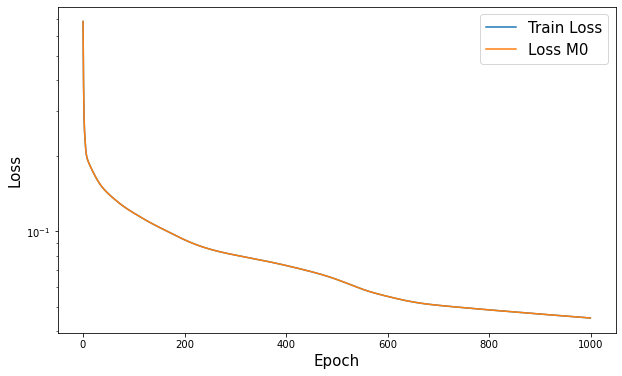

In [52]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")

plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [53]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 4.6745095
RMSE of after m0 4.500854
RMSE of after m0 5.4164824
RMSE of after m0 5.341151
RMSE of after m0 5.154116
RMSE of after m0 4.970905
RMSE of after m0 4.826448
RMSE of after m0 4.7032523
RMSE of after m0 4.781728
RMSE of after m0 4.8688045
RMSE of after m0 4.837168
RMSE of after m0 4.8473096
RMSE of after m0 4.7404757
RMSE of after m0 4.6804214
RMSE of after m0 4.904767
RMSE of after m0 4.9419546
RMSE of after m0 4.768781
RMSE of after m0 4.646522
RMSE of after m0 4.563911
RMSE of after m0 4.499128
RMSE of after m0 4.4724774
RMSE of after m0 4.4327264
RMSE of after m0 4.320589
RMSE of after m0 4.1568565
RMSE of after m0 3.9815125
RMSE of after m0 3.8224983
RMSE of after m0 3.759084
RMSE of after m0 3.7428799
RMSE of after m0 3.8006518
RMSE of after m0 3.7100773
RMSE of after m0 3.6589692
RMSE of after m0 3.5997074
RMSE of after m0 3.6222084
RMSE of after m0 3.6251848
RMSE of after m0 3.5742323
RMSE of after m0 3.4541984
RMSE of after m0 3.4695613
RMSE of after m

RMSE of after m0 8.172648
RMSE of after m0 8.6284685
RMSE of after m0 8.798279
RMSE of after m0 9.094453
RMSE of after m0 8.874819
RMSE of after m0 8.609921
RMSE of after m0 8.627783
RMSE of after m0 8.68664
RMSE of after m0 8.629264
RMSE of after m0 8.609012
RMSE of after m0 8.448926
RMSE of after m0 8.38851
RMSE of after m0 8.372012
RMSE of after m0 8.234313
RMSE of after m0 7.996371
RMSE of after m0 7.8397923
RMSE of after m0 7.7989693
RMSE of after m0 8.710995
RMSE of after m0 9.240482
RMSE of after m0 9.275512
RMSE of after m0 9.621254
RMSE of after m0 10.248873
RMSE of after m0 9.752481
RMSE of after m0 10.0546875
RMSE of after m0 10.345432
RMSE of after m0 10.149623
RMSE of after m0 10.201808
RMSE of after m0 9.482487
RMSE of after m0 8.612349
RMSE of after m0 8.374131
RMSE of after m0 8.46766
RMSE of after m0 7.8652663
RMSE of after m0 7.496718
RMSE of after m0 7.830648
RMSE of after m0 7.980733
RMSE of after m0 8.115963
RMSE of after m0 8.0575285
RMSE of after m0 7.7027345
RMS

RMSE of after m0 4.5605636
RMSE of after m0 4.684106
RMSE of after m0 4.784736
RMSE of after m0 4.889826
RMSE of after m0 4.986472
RMSE of after m0 5.059039
RMSE of after m0 4.9646363
RMSE of after m0 4.749974
RMSE of after m0 4.765259
RMSE of after m0 4.814454
RMSE of after m0 4.8022566
RMSE of after m0 4.819802
RMSE of after m0 4.8117785
RMSE of after m0 4.783224
RMSE of after m0 4.9105425
RMSE of after m0 5.047234
RMSE of after m0 5.097723
RMSE of after m0 5.305102
RMSE of after m0 5.5035367
RMSE of after m0 5.6468344
RMSE of after m0 5.512696
RMSE of after m0 5.440383
RMSE of after m0 5.435036
RMSE of after m0 5.41664
RMSE of after m0 5.334637
RMSE of after m0 5.249268
RMSE of after m0 5.128578
RMSE of after m0 5.056944
RMSE of after m0 5.046194
RMSE of after m0 5.0017343
RMSE of after m0 5.2027607
RMSE of after m0 5.124449
RMSE of after m0 5.2485666
RMSE of after m0 5.3042083
RMSE of after m0 5.2229605
RMSE of after m0 5.175774
RMSE of after m0 5.105341
RMSE of after m0 5.109783
R

RMSE of after m0 1.3160738
RMSE of after m0 1.3460697
RMSE of after m0 1.3823054
RMSE of after m0 1.3769238
RMSE of after m0 1.4208264
RMSE of after m0 1.4835423
RMSE of after m0 1.4857143
RMSE of after m0 1.5154179
RMSE of after m0 1.4770666
RMSE of after m0 1.5619898
RMSE of after m0 1.6397432
RMSE of after m0 1.6762369
RMSE of after m0 1.7384459
RMSE of after m0 1.7607183
RMSE of after m0 1.8350661
RMSE of after m0 1.9043672
RMSE of after m0 1.8658433
RMSE of after m0 1.8876599
RMSE of after m0 1.9140463
RMSE of after m0 1.9832273
RMSE of after m0 2.1608255
RMSE of after m0 2.075164
RMSE of after m0 2.1386714
RMSE of after m0 2.1735144
RMSE of after m0 2.2584653
RMSE of after m0 2.341921
RMSE of after m0 2.1532829
RMSE of after m0 2.130418
RMSE of after m0 2.1899743
RMSE of after m0 2.2187903
RMSE of after m0 2.2220013
RMSE of after m0 2.2272007
RMSE of after m0 2.3635538
RMSE of after m0 2.6157236
RMSE of after m0 2.6644912
RMSE of after m0 2.5631645
RMSE of after m0 2.6247725
RMSE

RMSE of after m0 9.598806
RMSE of after m0 9.426974
RMSE of after m0 9.354737
RMSE of after m0 9.127138
RMSE of after m0 8.878088
RMSE of after m0 8.495393
RMSE of after m0 8.149091
RMSE of after m0 8.433376
RMSE of after m0 8.198029
RMSE of after m0 8.110974
RMSE of after m0 8.104672
RMSE of after m0 7.873478
RMSE of after m0 7.5928626
RMSE of after m0 7.5336914
RMSE of after m0 6.98773
RMSE of after m0 6.703188
RMSE of after m0 6.5994678
RMSE of after m0 6.639328
RMSE of after m0 6.4790297
RMSE of after m0 6.3372173
RMSE of after m0 6.307685
RMSE of after m0 6.418348
RMSE of after m0 6.4855638
RMSE of after m0 6.2541156
RMSE of after m0 5.687138
RMSE of after m0 5.294088
RMSE of after m0 5.1938148
RMSE of after m0 5.093469
RMSE of after m0 4.993302
RMSE of after m0 4.945453
RMSE of after m0 4.9678264
RMSE of after m0 4.840275
RMSE of after m0 4.982599
RMSE of after m0 4.601375
RMSE of after m0 4.299408
RMSE of after m0 4.232167
RMSE of after m0 4.3592043
RMSE of after m0 3.8382833
RM

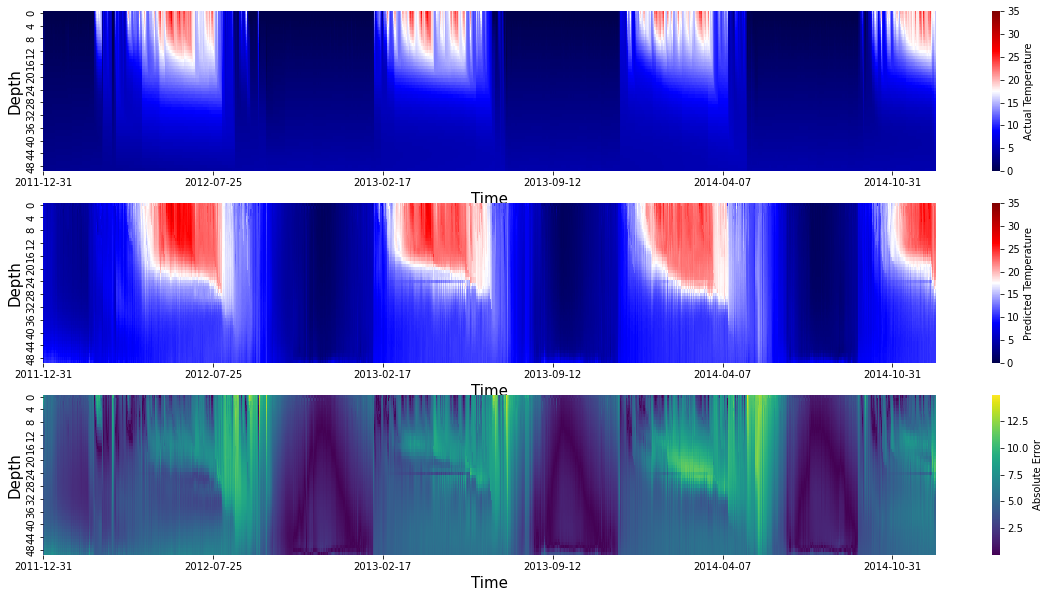

In [54]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

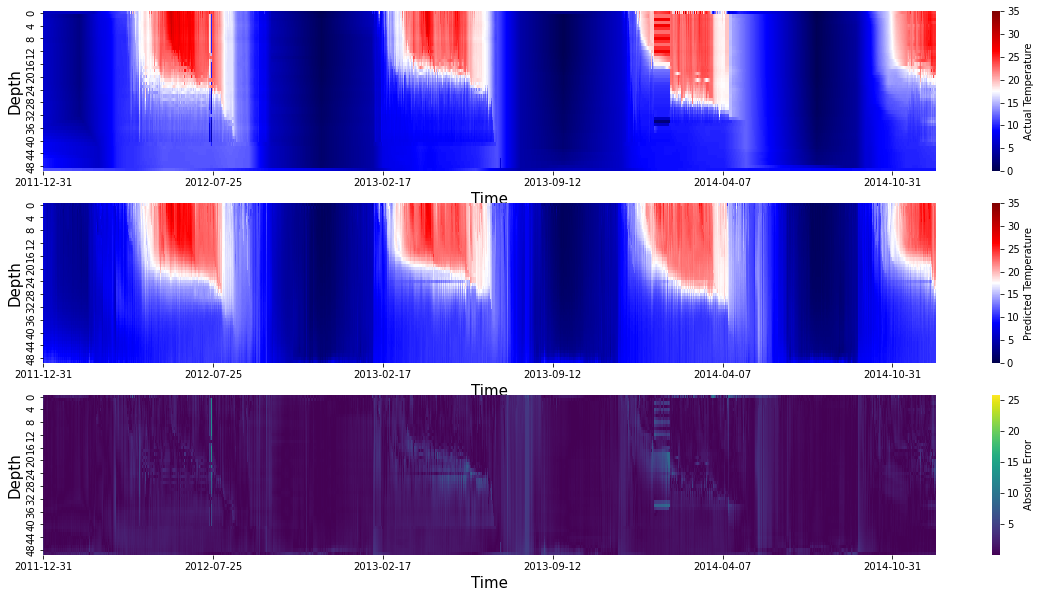

In [55]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [63]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 6.9826546
RMSE of after m0 6.944744
RMSE of after m0 6.655285
RMSE of after m0 6.5306826
RMSE of after m0 6.515683
RMSE of after m0 6.5332093
RMSE of after m0 6.680852
RMSE of after m0 6.74471
RMSE of after m0 6.8436303
RMSE of after m0 6.7769294
RMSE of after m0 6.5259914
RMSE of after m0 6.4471874
RMSE of after m0 6.5692225
RMSE of after m0 6.3747673
RMSE of after m0 6.2993073
RMSE of after m0 6.3484674
RMSE of after m0 6.88706
RMSE of after m0 7.228783
RMSE of after m0 7.124012
RMSE of after m0 7.027553
RMSE of after m0 6.7960405
RMSE of after m0 7.2071233
RMSE of after m0 7.36253
RMSE of after m0 7.1758614
RMSE of after m0 7.1118293
RMSE of after m0 7.0476336
RMSE of after m0 6.8018036
RMSE of after m0 6.4818773
RMSE of after m0 6.824233
RMSE of after m0 6.984351
RMSE of after m0 6.7289367
RMSE of after m0 6.747477
RMSE of after m0 6.879591
RMSE of after m0 6.870005
RMSE of after m0 6.9766564
RMSE of after m0 6.871347
RMSE of after m0 6.8021965
RMSE of after m0 6.8

RMSE of after m0 3.9430113
RMSE of after m0 3.9303317
RMSE of after m0 3.563413
RMSE of after m0 3.7312975
RMSE of after m0 3.9207673
RMSE of after m0 3.8539968
RMSE of after m0 3.4524572
RMSE of after m0 3.6161299
RMSE of after m0 3.6933877
RMSE of after m0 3.4198394
RMSE of after m0 3.383711
RMSE of after m0 3.5160606
RMSE of after m0 3.5259087
RMSE of after m0 3.2357824
RMSE of after m0 3.4680867
RMSE of after m0 3.4551163
RMSE of after m0 3.6485884
RMSE of after m0 3.70924
RMSE of after m0 3.8600078
RMSE of after m0 4.9203773
RMSE of after m0 4.844994
RMSE of after m0 4.4903164
RMSE of after m0 4.3540916
RMSE of after m0 4.5333424
RMSE of after m0 4.5198402
RMSE of after m0 4.4854484
RMSE of after m0 4.463558
RMSE of after m0 4.50506
RMSE of after m0 4.4061646
RMSE of after m0 4.5423613
RMSE of after m0 4.5224657
RMSE of after m0 4.454258
RMSE of after m0 4.5413375
RMSE of after m0 4.577699
RMSE of after m0 4.7036786
RMSE of after m0 4.622075
RMSE of after m0 4.474731
RMSE of after

RMSE of after m0 2.4236772
RMSE of after m0 2.3118792
RMSE of after m0 2.219851
RMSE of after m0 1.993969
RMSE of after m0 1.9659169
RMSE of after m0 1.8157167
RMSE of after m0 1.7301883
RMSE of after m0 1.7885013
RMSE of after m0 1.78973
RMSE of after m0 1.7225976
RMSE of after m0 1.6751224
RMSE of after m0 1.616198
RMSE of after m0 1.5897337
RMSE of after m0 1.5407485
RMSE of after m0 1.5240709
RMSE of after m0 1.4341408
RMSE of after m0 1.3983941
RMSE of after m0 1.3107908
RMSE of after m0 1.2613746
RMSE of after m0 1.1837494
RMSE of after m0 1.2255547
RMSE of after m0 1.198138
RMSE of after m0 1.1837531
RMSE of after m0 0.98535687
RMSE of after m0 0.97422004
RMSE of after m0 0.9909308
RMSE of after m0 1.1325443
RMSE of after m0 1.083148
RMSE of after m0 1.0512191
RMSE of after m0 1.1646128
RMSE of after m0 1.1425447
RMSE of after m0 1.1206595
RMSE of after m0 1.1033223
RMSE of after m0 1.2006103
RMSE of after m0 1.2136664
RMSE of after m0 1.243443
RMSE of after m0 1.3265433
RMSE of

RMSE of after m0 6.0489774
RMSE of after m0 6.2995963
RMSE of after m0 6.3135343
RMSE of after m0 5.820684
RMSE of after m0 5.511391
RMSE of after m0 6.0750813
RMSE of after m0 6.2287393
RMSE of after m0 6.311349
RMSE of after m0 6.346535
RMSE of after m0 6.4320345
RMSE of after m0 6.273751
RMSE of after m0 6.275521
RMSE of after m0 6.1637673
RMSE of after m0 6.323162
RMSE of after m0 6.7584553
RMSE of after m0 6.960866
RMSE of after m0 6.980638
RMSE of after m0 6.795285
RMSE of after m0 6.767989
RMSE of after m0 6.7310414
RMSE of after m0 6.35336
RMSE of after m0 5.8451176
RMSE of after m0 5.811593
RMSE of after m0 6.328111
RMSE of after m0 6.8864484
RMSE of after m0 7.292012
RMSE of after m0 7.390803
RMSE of after m0 7.7367992
RMSE of after m0 7.86986
RMSE of after m0 8.431936
RMSE of after m0 8.654092
RMSE of after m0 8.666597
RMSE of after m0 9.483178
RMSE of after m0 9.306379
RMSE of after m0 9.281291
RMSE of after m0 8.587842
RMSE of after m0 8.853036
RMSE of after m0 8.818821
RM

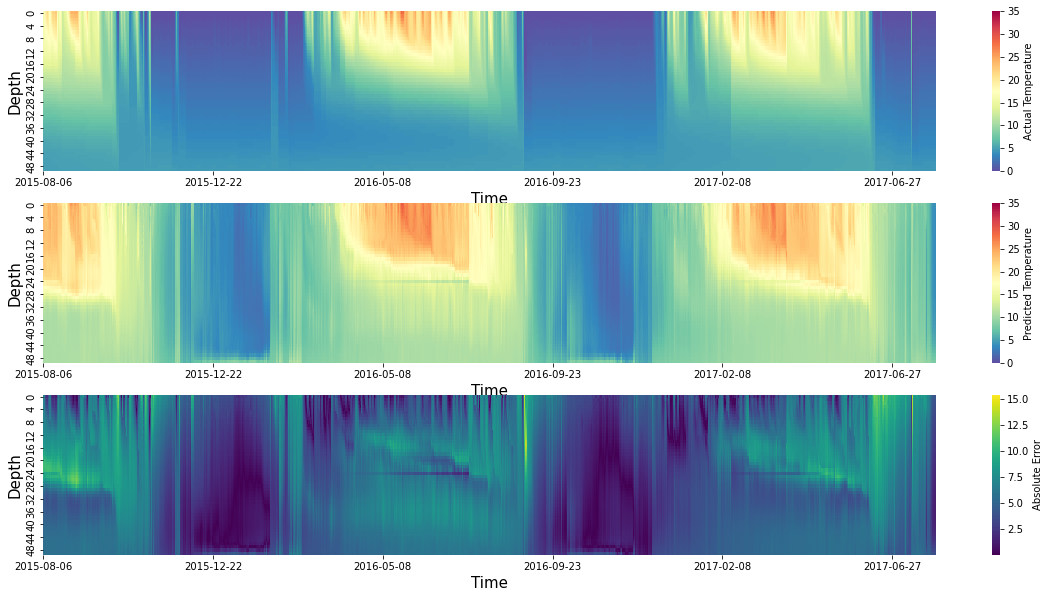

In [64]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

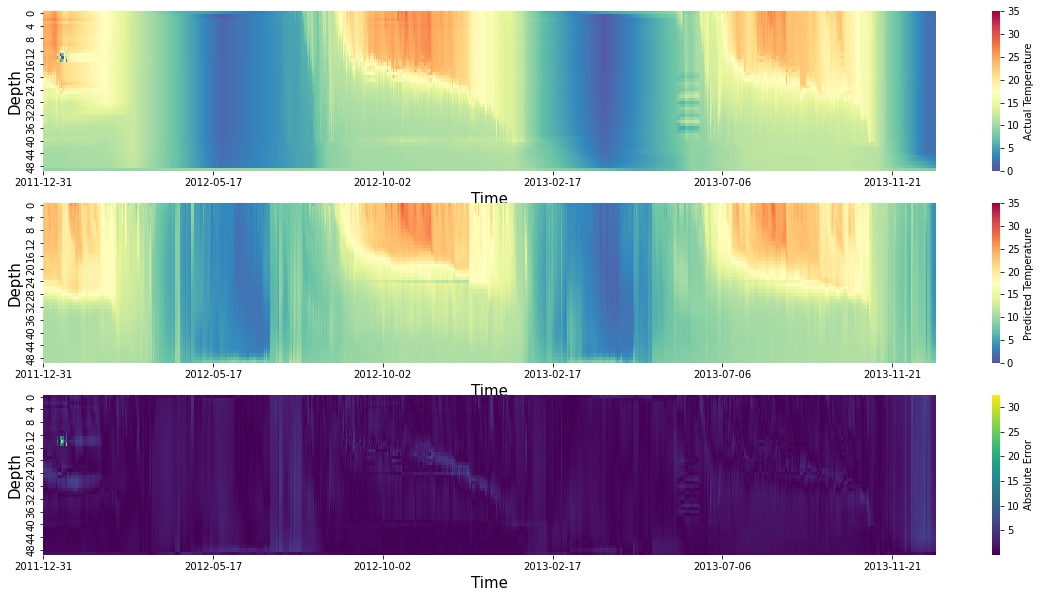

In [65]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

## Mixing Model

## Convection Model

## Ice Model

# Compute Model Similarity after Finetuning

In [59]:
# Freeze all models again and compute finetuned diffusivity values

In [60]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [61]:
PATH = f"./saved_models/directdeep_model_finetuned.pth"
torch.save(direct_model.state_dict(), PATH)